# Week 3: Using RNNs to predict time series

This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



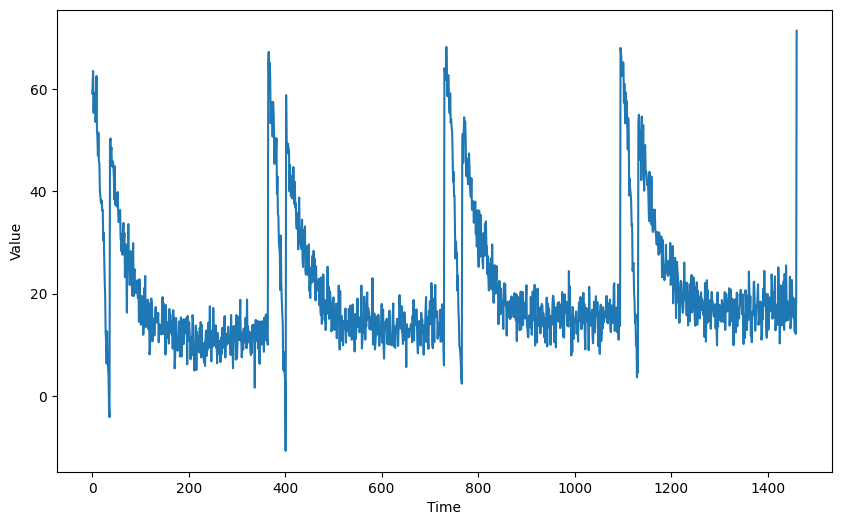

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

  #======= Complete here =====================
  #************** TO-DO *****************************
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
  #===============================================
    
    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
  #======= Complete here =====================
  #************** TO-DO *****************************
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    dataset = ds
  #===============================================
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [ ]:
def create_uncompiled_model():

    ### START CODE HERE

  #======= Complete here =====================
  #************** TO-DO *****************************
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
  #===============================================

    ### END CODE HERE

    return model

In [9]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 1s 22ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [10]:
def adjust_learning_rate():
    model = create_uncompiled_model()

    # callback that bumps the LR each epoch
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-6 * 10**(epoch / 20)
    )

    # ✔ use learning_rate instead of lr
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

    model.compile(
  #======= Complete here =====================
  loss=tf.keras.losses.Huber(),
  optimizer=optimizer,
  metrics=["mae"]
  #===============================================
    )

    history = model.fit(dataset, epochs=10, callbacks=[lr_schedule])
    return history


In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/10
34/34 [==============================] - 1s 4ms/step - loss: 92.5685 - mae: 93.0668 - lr: 1.0000e-06
Epoch 2/10
34/34 [==============================] - 0s 4ms/step - loss: 12.6510 - mae: 13.1427 - lr: 1.1220e-06
Epoch 3/10
34/34 [==============================] - 0s 4ms/step - loss: 8.9649 - mae: 9.4531 - lr: 1.2589e-06
Epoch 4/10
34/34 [==============================] - 0s 6ms/step - loss: 7.6672 - mae: 8.1490 - lr: 1.4125e-06
Epoch 5/10
34/34 [==============================] - 0s 2ms/step - loss: 6.5991 - mae: 7.0775 - lr: 1.5849e-06
Epoch 6/10
34/34 [==============================] - 0s 2ms/step - loss: 5.9148 - mae: 6.3914 - lr: 1.7783e-06
Epoch 7/10
34/34 [==============================] - 0s 2ms/step - loss: 5.2357 - mae: 5.7122 - lr: 1.9953e-06
Epoch 8/10
34/34 [==============================] - 0s 3ms/step - loss: 4.6677 - mae: 5.1425 - lr: 2.2387e-06
Epoch 9/10
34/34 [==============================] - 0s 3ms/step - loss: 4.0416 - mae: 4.5089 - lr: 2.5119e-06
Epoch 

: 

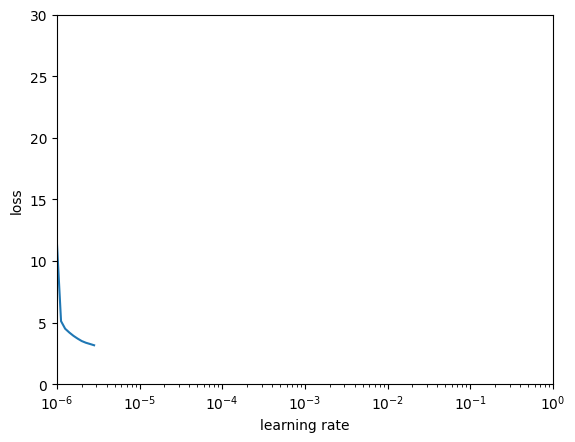

In [ ]:
# number of epochs you actually ran
epochs = len(lr_history.history["loss"])

# rebuild the schedule you passed to LearningRateScheduler
lrs = 1e-6 * (10 ** (np.arange(epochs) / 20.0))

plt.semilogx(lrs, lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()


## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [ ]:
def create_model():
    tf.random.set_seed(51)

    model = create_uncompiled_model()

    # ✔ modern Keras: use learning_rate=
    model.compile(
  #======= Complete here =====================
  #************** TO-DO *****************************
  #===============================================
    )
    return model

# build and train
model   = create_model()
history = model.fit(dataset, epochs=3)


Epoch 1/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 976.3788 - mae: 25.0772
Epoch 2/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 207.9372 - mae: 9.2150
Epoch 3/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 189.7164 - mae: 8.6064


In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=10)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 726.9924 - mae: 23.8691
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 218.3160 - mae: 11.2464
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 163.4954 - mae: 9.8619
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 128.5197 - mae: 8.7926
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 104.3093 - mae: 7.4140
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 107.5776 - mae: 7.2969
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 84.5252 - mae: 6.0742
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 75.1078 - mae: 5.9793
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 67.5613 - mae: 5.3619
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 67.0298 - mae: 5.2011


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


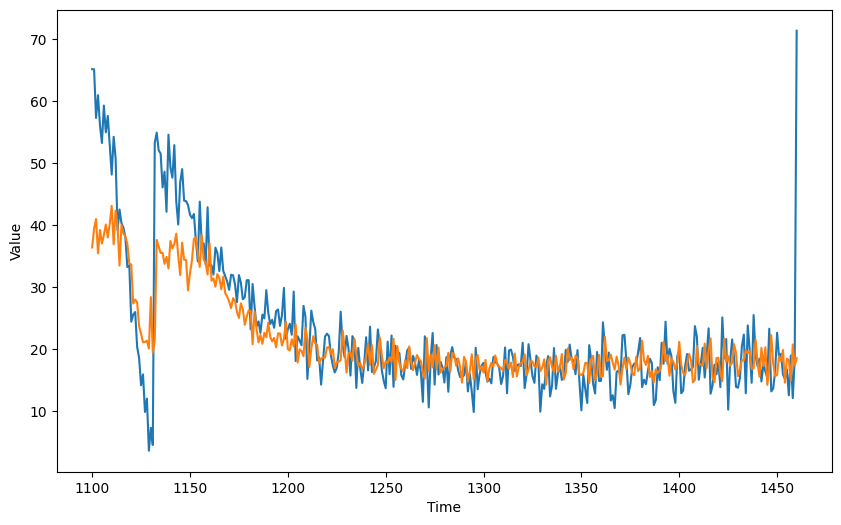

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [17]:
def compute_metrics(true_series, forecast):
  #======= Complete here =====================
  #************** TO-DO *****************************
  #===============================================
    return mse, mae


mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 48.53, mae: 4.46 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [19]:
# write the model as a single Keras-v3 archive
model.save("my_model.keras")

# (optional) gzip it if you really need a .tar.gz artefact
import gzip, shutil, pathlib
with open("my_model.keras", "rb") as src, gzip.open("my_model.keras.gz", "wb") as dst:
    shutil.copyfileobj(src, dst)
print("Wrote", pathlib.Path("my_model.keras").stat().st_size, "bytes")

Wrote 107173 bytes


**Congratulations on finishing this week's assignment!**

**Keep it up!**